In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [3]:
import os
import numpy as np

import pandas as pd
import cudf as gd

from cuml.manifold.umap import UMAP as cumlUMAP

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

In [6]:
DATASET_ID = 'mouse_usv_long'

In [7]:
window_length_ms = 5
hop_length_ms = 1
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

5

In [8]:
mouse = '832'

### load data

In [9]:
windows_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_windows_' + str(window_length_ms)+'.npy')
windows  = np.load(windows_loc.as_posix())
np.shape(windows)

(104795, 160)

In [10]:
spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_spec.npy')
spec_large  = np.load(spec_loc.as_posix())
np.shape(spec_large)

(820, 104799)

In [11]:
spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_spec_small.npy')
spec  = np.load(spec_loc.as_posix())
np.shape(spec)

(32, 104799)

In [12]:
onsets_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_onsets_offsets.npy')
onsets, offsets  = np.load(onsets_loc.as_posix())
np.shape(onsets), np.shape(offsets)

((490,), (490,))

In [13]:
excess = (np.shape(spec)[1] - len(windows))
excess

4

In [14]:
#spec = spec[:, (int(np.ceil(excess/2))):-int(np.floor(excess/2))]
spec = spec[:, :-int(excess)]

In [15]:
np.shape(spec)

(32, 104795)

In [16]:
mouse = '832_1'

windows_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_windows_' + str(window_length_ms)+'.npy')
windows2  = np.load(windows_loc.as_posix())
np.shape(windows)

spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_spec.npy')
spec_large2  = np.load(spec_loc.as_posix())
np.shape(spec_large)

spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_spec_small.npy')
spec2  = np.load(spec_loc.as_posix())
np.shape(spec)

onsets_loc = DATA_DIR/'umap_windows' / DATASET_ID / (mouse + '_onsets_offsets.npy')
onsets2, offsets2  = np.load(onsets_loc.as_posix())
np.shape(onsets), np.shape(offsets)

excess2 = (np.shape(spec2)[1] - len(windows2))
excess2

#spec = spec[:, (int(np.ceil(excess/2))):-int(np.floor(excess/2))]
spec2 = spec2[:, :-int(excess2)]

In [17]:
windows = np.vstack([windows, windows2])

In [18]:
spec_large = np.hstack([spec_large2, spec_large2])

In [19]:
spec = np.hstack([spec, spec2])

In [20]:
onsets2 += 104799 / 1000
offsets2 += 104799 / 1000

In [21]:
onsets = np.concatenate([onsets, onsets2])

In [22]:
offsets = np.concatenate([offsets, offsets2])

In [23]:
len(offsets)

1111

In [24]:
np.shape(spec), len(windows)

((32, 245827), 245827)

### plot spec

In [25]:
rate = 250000

In [26]:
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec

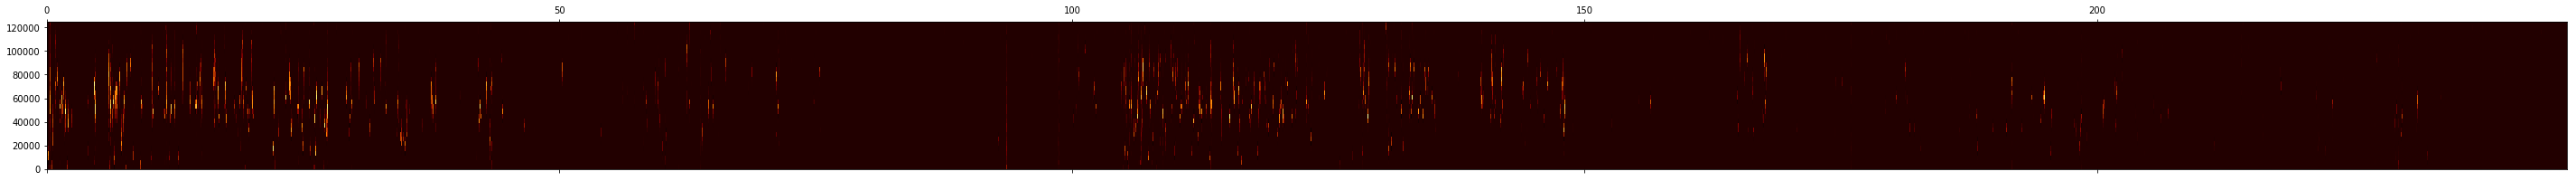

In [27]:
fig, ax = plt.subplots(figsize=(50,3))
plot_spec(spec, fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
plt.show()

In [28]:
from avgn.visualization.spectrogram import draw_spec_set

In [29]:
segs = [
    spec[:, int(onset * 1000 / hop_length_ms) : int(offset * 1000 / hop_length_ms)]
    for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets)))
]
#segs = [norm(i) for i in segs if np.prod(np.shape(i)) > 0]

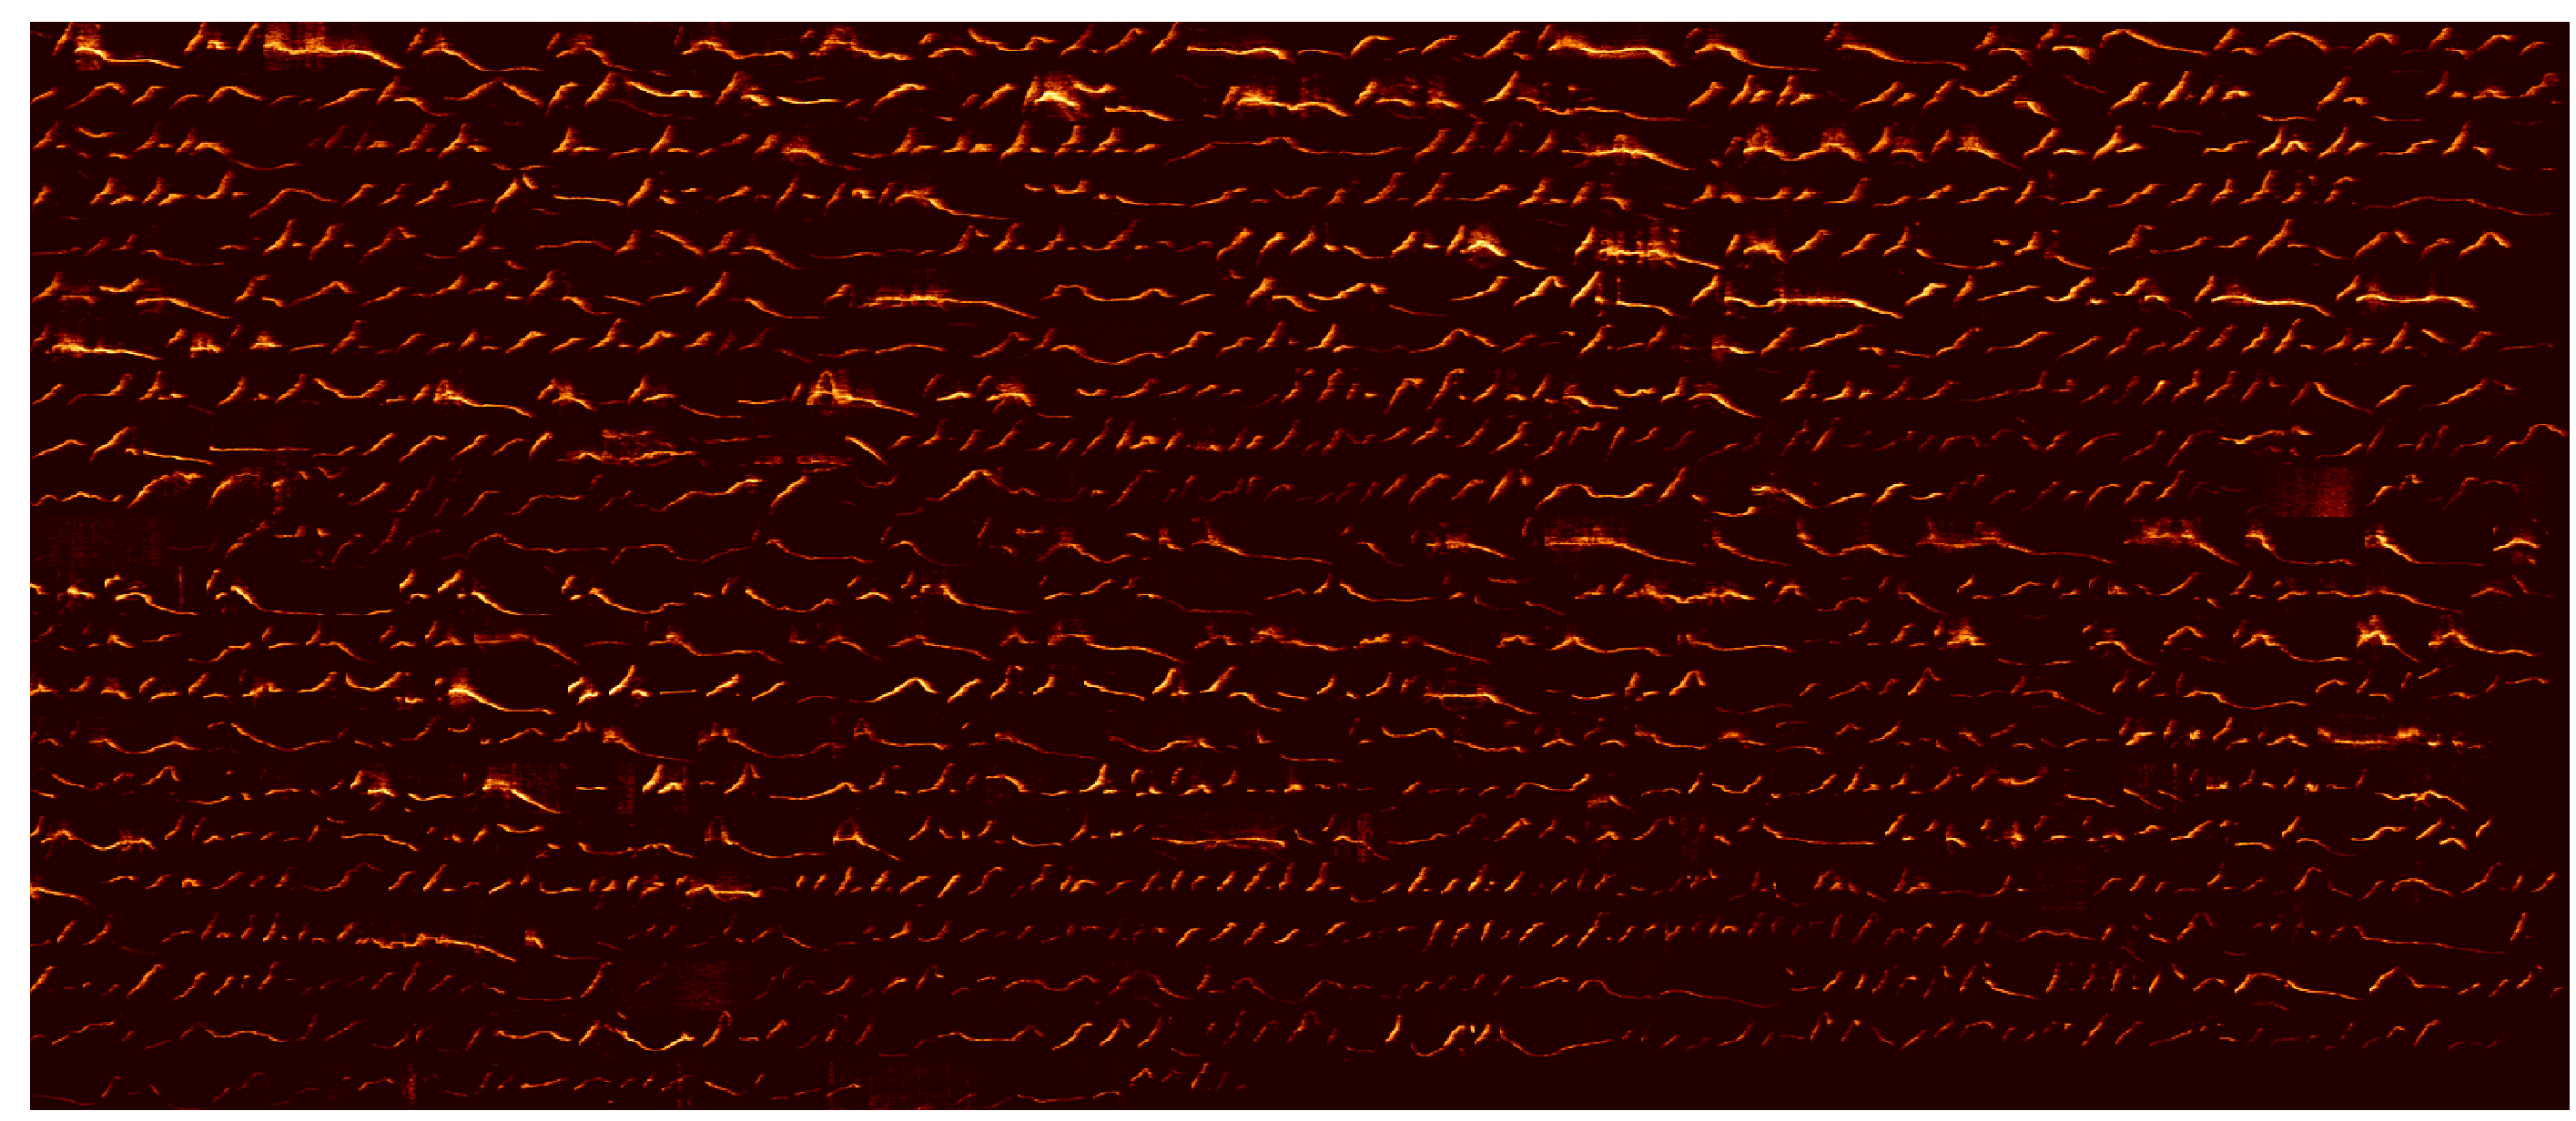

In [30]:
draw_spec_set(segs, zoom=1, maxrows=60, colsize=50)

### create embedding

In [31]:
cuml_umap = cumlUMAP(min_dist = 0.5)
embedding = cuml_umap.fit_transform(windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [32]:
np.shape(embedding), np.min(embedding, axis=0), np.max(embedding, axis=0)

((245827, 2),
 array([-13985.734375  , -47278.31640625]),
 array([6501.73632812, 7758.83154297]))

(-15, 15)

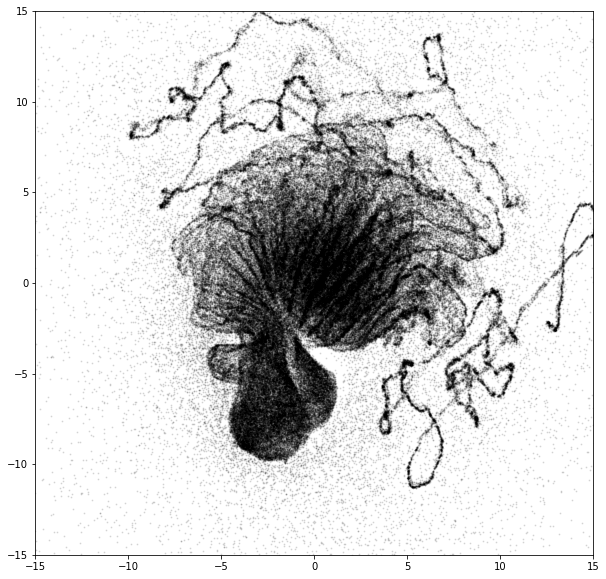

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.1, s = 1, color='k')
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

In [34]:
from avgn.utils.paths import FIGURE_DIR,ensure_dir
from avgn.utils.general import save_fig

In [35]:
ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)

### create power-mask for sequences

In [36]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [37]:
mask = np.expand_dims(norm(np.max(spec, axis=0)),1)
mask = (mask+1e-5)**1

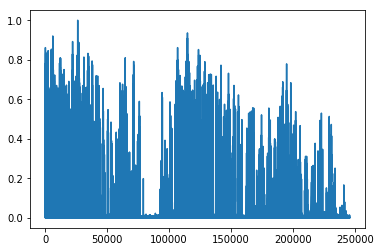

In [38]:
plt.plot(mask)

### plot seqs

In [66]:
xlims = [-6.5, 2]
ylims = [-10.5, 0]

In [58]:
np.shape(mask)

(245827, 1)

In [59]:
import copy

In [60]:
np.shape(embedding)

(245827, 2)

(-10.5, -2)

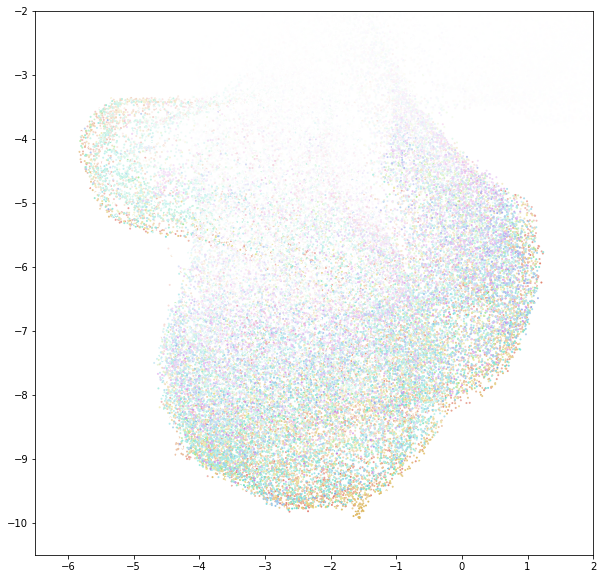

In [61]:
window_z = copy.deepcopy(embedding)
fig, ax = plt.subplots(figsize=(10,10))
curr_idx = 0
cols = np.array(sns.color_palette('hls', len(window_z)))
cols = 1-((1-cols) * mask) #+ (add*(mask))
ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 1, c= cols)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
#ax.axis('off')

#save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('umap_seqs_single_'+key), save_png=True)

### plot segments individually

(-6.5, 2.0, -10.5, -2.0)

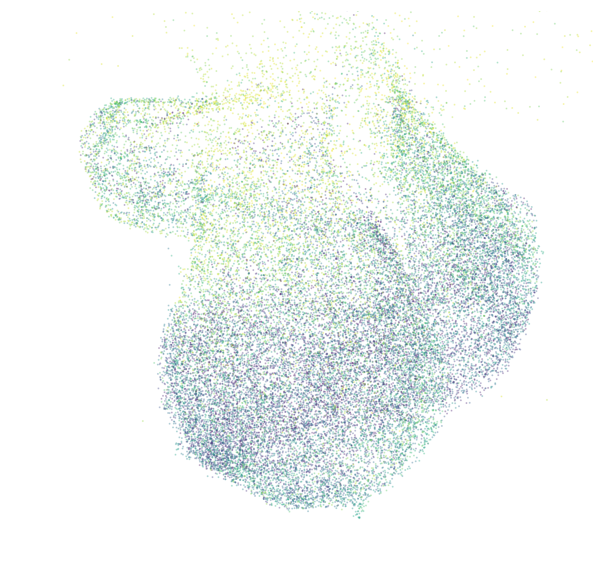

In [62]:
fig, ax = plt.subplots(figsize=(10,10))

for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    cols = np.array(sns.color_palette('viridis', len(window_z)))
    ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.25, s = 1, c= cols)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

(-6.5, 2.0, -10.5, -2.0)

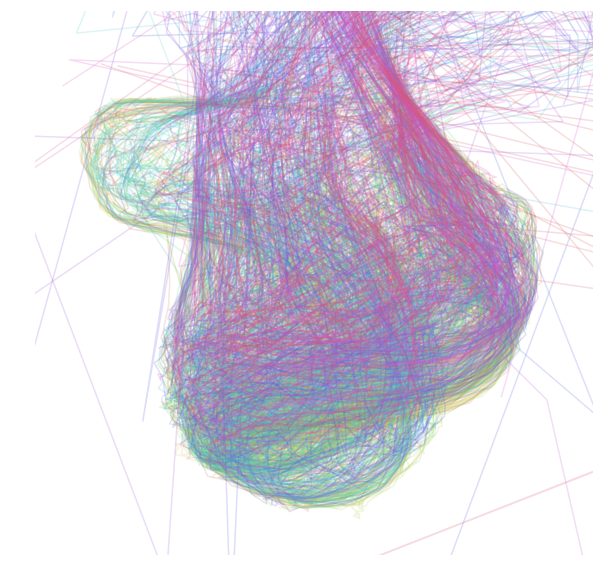

In [63]:
cols = np.array(sns.color_palette('hls', len(onsets)))
fig, ax = plt.subplots(figsize=(10,10))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    col = cols[oi]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.2, color= col)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')
#save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('castellucci_832_5ms'), save_png=True)

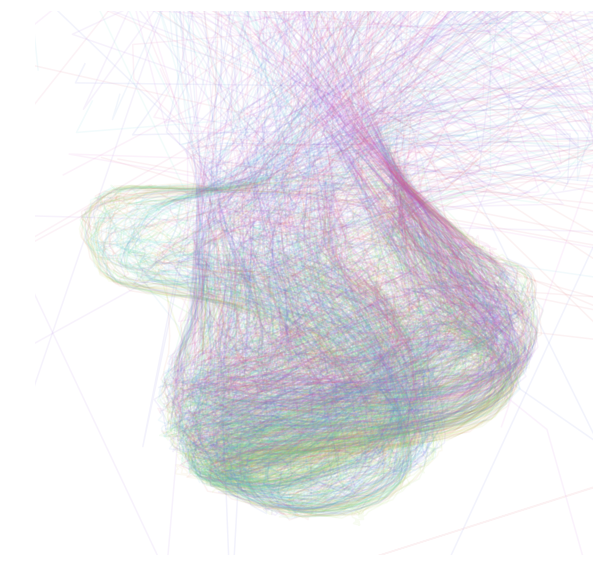

In [67]:
cols = np.array(sns.color_palette('hls', len(onsets)))
fig, ax = plt.subplots(figsize=(10,10))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    col = cols[oi]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.075, color= col)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

#save_fig(FIGURE_DIR / 'mouse_traj' / '5ms-color-seq-832', dpi=300, save_jpg=True, save_png=True)